In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Packages needed

In [21]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.linalg import norm
from mplstereonet.stereonet_math import pole, cart2sph, geographic2pole,sph2cart
from scipy.integrate import dblquad
# Set default font size for plots:
font = {'size'   : 20}
plt.rc('font',**font)

def normal_shear(sigma,n):
    '''Function to estimate the value of the normal stress and shear stress on plane with normal vector n.
    Input:
    sigma = stress tensor 
    n = normal vector
    Output:
    sigma_n = normal stress magnitude
    tau_n =shear stress magnitude
    '''
    #1) Projection of the stress tensor on the plane (vector on plane)
    Tn=np.dot(sigma,n)
    #2) Projection of Tn in the direction of the normal vector
    sigma_n=np.dot(Tn,n)
    #3) Pythagorean decomposition of the vectors to get the shear stress
    tau_n=np.sqrt(LA.norm(Tn)**2-sigma_n**2)
    #4) Print the values
    #print('The normal stress for the plane described by the normal vector: ',sigma_n)
    #print('The shear stress for the plane described by the normal vector: ',tau_n)
    return sigma_n, tau_n

def fnormal(strike, dip):
    '''Calculate the normal vector of a plane from the strike azumuth and dip in degrees.  
    The strike should be between 0 and 360 degrees (negative ok). The dip between 0 and 90 degrees.
    The dip should be measured in the direction such that the fault dips to your right when looking in the direction
    of the strike.'''
    deg_to_rad=np.pi/180
    strike=strike*deg_to_rad
    dip=dip*deg_to_rad
    n=np.zeros(3) #Vector of 3 components
    n[2]=-np.sin(dip)*np.sin(strike) #North component
    n[1]=np.sin(dip)*np.cos(strike) #East component
    n[0]=-np.cos(dip) #Down component
    return -n

def dip2strike(azim,dip):
    '''Convert dip azimuth to strike (right-hand rule convention)'''
    if azim < 90:
        strike=(azim-90)+360
    else:
        strike=azim-90
    return strike,dip

def axis_poles(strikesp,dipsp):
    '''Find the average axis of all the poles'''
    #Find the average pole using linear algebra
    #Make a matrix of all the pole vectors 
    V=[]
    for i in range(0,len(strikesp)):
        lon,lat=pole(strikesp[i],dipsp[i])
        x,y,z=sph2cart(lon,lat)
        v=np.array([x,y,z])
        V=np.append(V,v)
    #Reshape the array into a n-by-3 matrix  
    V=V.reshape((len(strikesp),3))
    M=V.T@V #Calculate the 3-by-3 square matrix
    w,E=LA.eig(M) #Eigenvectors of M are the principal directions of stress
    print('The Eigenvectors: \n',E)
    print('The Eigenvalues:',w)
    print('The trace of the Eigenvalues should be N (number of points): ',np.sum(np.diag(w)))
    return w,E

def sy_matrices2vec(E,k1,k2):
    '''The parameter space trasnformation of Sato & Yamaji (2006). From E,K to 5-component vector'''
    phi=k2/k1
    rho=np.sqrt(k1**2+k1*k2+k2**2)
    const=1/(np.sqrt(3*phi**2-3*phi+3))
    s=const*np.diag(np.array([2-phi,2*phi-1,-phi-1]))
    vs=E@s@E.T #varsigma matrix
    #Calculate the vector components
    a,b,c=((np.sqrt(2)/4)+(np.sqrt(6)/12)),((np.sqrt(2)/4)-(np.sqrt(6)/12)),(1/np.sqrt(6))
    xi1=-a*vs[0,0]+b*vs[1,1]+c*vs[2,2]
    xi2=b*vs[0,0]-a*vs[1,1]+c*vs[2,2]
    xi3=vs[1,2]
    xi4=vs[2,0]
    xi5=vs[0,1]
    xi=np.array([xi1,xi2,xi3,xi4,xi5])
    x=rho*xi #The vector in the space formed by E and K.
    return vs,rho,xi,x

def sy_vec2matrices(x):
    '''The parameter space trasnformation of Sato & Yamaji (2006). From 5-component vector to E,K'''
    vs=np.zeros((3,3))
    rho=LA.norm(x)
    xi1,xi2,xi3,xi4,xi5=x/rho
    a,b,c=((1/np.sqrt(2))+(1/np.sqrt(6))),((1/np.sqrt(2))-(1/np.sqrt(6))),(np.sqrt(2/3))
    vs[0,0]=-a*xi1+b*xi2
    vs[1,1]=b*xi1-a*xi2
    vs[2,2]=c*(xi1+xi2)
    vs[1,2]=xi3
    vs[2,1]=xi3
    vs[2,0]=xi4
    vs[0,2]=xi4
    vs[0,1]=xi5
    vs[1,0]=xi5
    w,E=LA.eig(vs) #must be sorted from max. eigenvalue to min. eigenvalue
    phi=(w[1]-w[2])/(w[0]-w[2])
    k1=-rho/np.sqrt(phi**2+phi+1)
    k2=phi*k1
    return k1,k2,E

def norm_bingham(k1,k2):
    '''Integral over the sphere to normalize the distribution'''
    phi=np.linspace(0,2*np.pi,180) #180
    theta=np.linspace(0,np.pi,90) #90
    dphi=np.mean(np.diff(phi))
    dtheta=np.mean(np.diff(theta))
    dA=dphi*dtheta
    c=1/(4*np.pi)
    Sum=0
    for i in range(0,len(phi)):
        for j in range(0,len(theta)):
            Sum=Sum+np.exp((k1*np.cos(phi[i])**2+k2*np.sin(phi[i])**2)*np.sin(theta[j])**2)*np.sin(theta[j])*dA
    return c*Sum

def norm_bingham_onstott(k1,k2):
    '''Normalization of the Bingham distribution by solving the integral'''
    def integrand(theta, phi):
        '''Onstott (1980) formula for the integral. Eq. (8) page 1501.'''
        return ((4*np.pi)**-1)*np.exp((k1*np.cos(phi)**2+k2*np.sin(phi)**2)*np.sin(theta)**2)*np.sin(theta)
    d, err = dblquad(integrand, 0, 2*np.pi,lambda phi: 0,lambda phi: np.pi)
    return d

def bingham_asymp(k1,k2):
    '''Asymptotic expansion (Bingham, 1974) when k1 has large values with respect to k2
    Use for cases when k1/k2 > 10 or k1/k2 >> 10'''
    return 1/(2*(np.sqrt(k1*k2)))

def d_intgrl(k1,k2):
    '''The normalization of the Bingham distribution from Strelitz (1989)'''
    tol=1e-25
    p_factor=1.0
    d=p_factor
    if (k1!=0.0):
        r=k1/k2
    else:
        r=0.0
        k2=k1
        k1=0.0
    if (np.abs(k2)<1.0):
        ktemp=k2
        k2=k1
        k1=ktemp
    ip=1
    new_term=1 #Added term to initialize a valid condition
    while (np.abs(new_term)>tol):
        p=ip
        p_factor=p_factor*k2/p
        p_term=p_factor/(2.0*p+1.0)
        bpq=1.0
        q_value=bpq
        for iq in range(0,ip):
            q=iq
            bpq=bpq*((p-q)*(q+0.5))/((p-q-0.5)*(q+1.0))*r
            q_value=q_value+bpq
        new_term=q_value*p_term
        d=d+new_term
        ip=ip+1
    return d

def bingham_d(k1,k2,ws):
    '''Choose the best algorithm to compute d(k1,k2)
    ws are the sorted eigenvalues (ws[0]=min, ws[1]=int)'''
    r=k1/k2
    if (ws[0]>=0.02)&(ws[0]<=0.32)&(ws[1]>=0.02)&(ws[1]<=0.48): #Table values of Mardia and Zemrock 1977
        d=4*np.pi*d_intgrl(k1,k2)
    elif (r>10)|(np.abs(k1)>100):
        d=4*np.pi*bingham_asymp(k1,k2)
    else:
        d=4*np.pi*norm_bingham_onstott(k1,k2)
    return d

def sort_eig(w,E):
    '''Sort the eigenvectors according to the order of eigenvalues'''
    ws=np.sort(w)
    Es=E[:,w.argsort()]
    return ws,Es

def plot_bingham(E,k1,k2):
    '''Plot the Bingham distribution from the eigenvectors E and eigenvalues k1 and k2 \n
    The matrix E should be ordered (sorted) according to the order of the eigenvalues k1 and k2'''
    if (k1>k2) | (k1>0):
        print('The conditions are not met. k1 must be negative and less than or equal to k2')
    else:
        #Calculate the value of the ration of k2 to k1 (phi)
        PHI=k2/k1 #The value of PHI as in Yamaji (2010)

        #Define the K matrix
        K=np.diag(np.array([k1,k2,0]))
        
        #The matrix to be multiplied
        sigma_r=E@K@E.T #Proper multiplication or this -> [np.dot(E,np.dot(sigma_0,E.T))]
        
        #Locations where to estimate the values on the stereonet in lon, lat
        azims=np.linspace(0,360,100)
        dips=np.linspace(0,90,30)

        ###########PLOTTING IN LAMBERT COORDINATES########################################################### 
        long=[]
        lati=[]
        sigmas_n=[]
        for i in range(0,len(azims)):
            for j in range(0,len(dips)):
                strike,dip=dip2strike(azims[i],dips[j])
                lon,lat=pole(strike,dip) #Get the pole in (lon,lat) of a plane of given strike and dip
                long=np.append(long,lon) #store the lon coordinates
                lati=np.append(lati,lat) #store the lat coordinates
                n=fnormal(strike, dip)
                sigma_n,tau_n=normal_shear(sigma_r,n)
                sigmas_n=np.append(sigmas_n,np.exp(sigma_n)) #A minus in the exponent gives the right answer 
        #The normalization constant (A)
        #A=norm_bingham(k1,k2)#np.sum(sigmas_n) #The rough integration
        A=4*np.pi*norm_bingham_onstott(k1,k2)

        #Grid for the angles and dips
        LON=long.reshape((len(azims),len(dips)))      
        LAT=lati.reshape((len(azims),len(dips)))   
        #Values of the stresses reshaped to match the grid defined 
        values=(1/A)*sigmas_n.reshape((len(azims),len(dips))) #Reshape the sigmas to match the grid size for contourf
        #Plot 
        fig,ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))
        plt.title('$\Phi$: '+np.str(PHI)+', $\kappa_1$: '+np.str(k1)+', $\kappa_2$: '+np.str(k2)+'')
        p1=ax.contourf(LON, LAT, values,10)
        ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
        ax.grid(True) #Remove the grid lines
        #ax.set_xticklabels(['90', '','0', '', '270', '', '180', ''])
        #Define the Colorbar
        #-- obtaining the colormap limits
        vmin,vmax = p1.get_clim()
        #-- Defining a normalised scale
        cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        #-- Creating a new axes at the right side
        ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])
        #-- Plotting the colormap in the created axes
        cb1 = mpl.colorbar.ColorbarBase(ax3, norm=cNorm)
        #Plot the eigenvectors and auxiliary planes of the matrix
        for i in range(0,len(E)):
            x,y,z=E[:,i] #Cartesian coordinates of eigenvector
            lon,lat=cart2sph(x,y,z)
            strike,dip=geographic2pole(lon,lat)
            #ax.pole(strike,dip,markersize=10,color='r')
            #ax.plane(strike,dip,'-.',lw=2,color='m')
            ax.pole(strike,dip,markersize=10,label='$e_'+np.str(i+1)+'$')
            ax.plane(strike,dip,'-.',lw=2,color='m')
            ax.legend()
            #print(x,y,z)
        ax.grid(True) #Remove the grid lines
        plt.show()
    return 

def pbingham(n,A):
    '''The Bingham distribution of a symmetric matrix in Python
    ################################
    #### Simulating from a Bingham distribution
    #### Tsagris Michail 02/2014
    #### mtsagris@yahoo.gr
    #### References: A new method to simulate the Bingham and related distributions
    #### in directional data analysis with applications
    #### Kent J.T., Ganeiber A.M. and Mardia K.V. (2013)
    #### http://arxiv.org/pdf/1310.8110v1.pdf
    #### and
    #### Exact Bayesian Inference for the Bingham Distribution
    #### C.J. Fallaize and T. Kypraios (2014)
    #### http://arxiv.org/pdf/1401.2894v1.pdf
    #### Original R function: rbingham(n, A)
    ################################

    ######### Simulation using any symmetric matrix A
    xc,yc,zc=pbingham(n, A)
    ######### Output
    xc,yc,zc are the coordinates of unit vectors on the sphere'''
    from numpy.random import random as runif
    p=len(A)-1
    #print('Dimension of Square Matrix',p)
    lam,E=LA.eig(A)
    #lam,E=sort_eig(lam,E)
    #print('The eigenvalues: ',lam)
    #print('The eigenvectors \n: ',V)
    lam=lam-lam[p]
    #print('The eigenvalues substracting the last term: ',lam)
    #print('The sorted eigenvalues: ',lam)
    #print('The sorted eigenvectors \n: ',V)
    nsamp=0
    X=[]
    qa=len(lam)
    mu=np.zeros(qa) #Zero means
    sigacginv = 1 + 2 * lam
    SigACG = np.sqrt( 1 / ( 1 + 2 * lam ) ) #standard deviations
    Ntry = 0
    #print('mu vector: ',mu)
    #print('Length of eigenvalue vector: ',qa)
    #print('sigacginv :',sigacginv)
    #print('SigACG :',SigACG)
    while nsamp < n:
        xsamp=False
        while (not xsamp):
            yp=np.random.normal(mu,SigACG,qa)
            y=yp/np.sqrt(np.sum(yp**2))
            lratio = -np.sum(y**2 *lam)-qa/2 *np.log(qa)+0.5*(qa-1)+qa/2 *np.log(np.sum(y**2 *sigacginv))
            if (np.log(runif(1)) < lratio):
                X=np.append(X,y)
                xsamp=True
                nsamp=nsamp+1
            Ntry=Ntry+1
    x=X.reshape((n,qa)) #n normal vectors
    xc,yc,zc=E@x.T
    return xc,yc,zc

def pbingham_EK(n,E,k1,k2):
    '''The Bingham distribution from the principal directions and concentrations
    k1 and k2.  k1 and k2 must be negative numbers
    ################################
    #### Simulating from a Bingham distribution based on the principal directions
    #### inferred from a set of poles and their concentrations.
    #### 
    ################################

    ######### Simulation using any symmetric matrix A
    xc,yc,zc=pbingham(n,E,k1,k2)
    ######### Output
    xc,yc,zc are the coordinates of unit vectors on the sphere'''
    from numpy.random import random as runif
    p=len(E)-1
    #print('Dimension of Square Matrix',p)
    #lam,E=LA.eig(A)
    #print('The eigenvalues: ',lam)
    #print('The eigenvectors \n: ',V)
    lam=-np.array([k1,k2,0])
    #lam,E=sort_eig(lam,E)
    #print('The eigenvalues substracting the last term: ',lam)
    #print('The sorted eigenvalues: ',lam)
    #print('The sorted eigenvectors \n: ',V)
    nsamp=0
    X=[]
    qa=len(lam)
    mu=np.zeros(qa) #Zero means
    sigacginv = 1 + 2 * lam
    SigACG = np.sqrt( 1 / ( 1 + 2 * lam ) ) #standard deviations
    Ntry = 0
    #print('mu vector: ',mu)
    #print('Length of eigenvalue vector: ',qa)
    #print('sigacginv :',sigacginv)
    #print('SigACG :',SigACG)
    while nsamp < n:
        xsamp=False
        while (not xsamp):
            yp=np.random.normal(mu,SigACG,qa)
            y=yp/np.sqrt(np.sum(yp**2))
            lratio = -np.sum(y**2 *lam)-qa/2 *np.log(qa)+0.5*(qa-1)+qa/2 *np.log(np.sum(y**2 *sigacginv))
            if (np.log(runif(1)) < lratio):
                X=np.append(X,y)
                xsamp=True
                nsamp=nsamp+1
            Ntry=Ntry+1
    x=X.reshape((n,qa)) #n normal vectors
    xc,yc,zc=E@x.T
    return xc,yc,zc

def prob_bingham_ad(E,k1,k2,azims,dips):
    '''Returns the Bingham probability values from the eigenvectors E and eigenvalues k1 and k2 \n
    The matrix E should be ordered (sorted) according to the order of the eigenvalues k1 and k2 \n
    azims, dips are locations of poles where to estimate the values on the stereonet in lon, lat'''
    if (k1>k2) | (k1>0):
        print('The conditions are not met. k1 must be negative and less than or equal to k2')
    else:
        #Calculate the value of the ration of k2 to k1 (phi)
        #PHI=k2/k1 #The value of PHI as in Yamaji (2010)

        #Define the K matrix
        K=np.diag(np.array([k1,k2,0]))
        
        #The matrix to be multiplied
        sigma_r=E@K@E.T #Proper multiplication or this -> [np.dot(E,np.dot(sigma_0,E.T))]
        
        #Locations where to estimate the values on the stereonet in lon, lat
        #azims=np.linspace(0,360,100)
        #dips=np.linspace(0,90,30)

        ###########CALCULATING THE VALUES########################################################### 
        sigmas_n=[]
        for i in range(0,len(azims)):
            strike,dip=dip2strike(azims[i],dips[i])
            n=fnormal(strike, dip)
            sigma_n,tau_n=normal_shear(sigma_r,n)
            sigmas_n=np.append(sigmas_n,np.exp(sigma_n)) #A minus in the exponent gives the right answer 
        #The normalization constant (A)
        #A=norm_bingham(k1,k2)#np.sum(sigmas_n) #The rough integration
        A=4*np.pi*norm_bingham_onstott(k1,k2)
        return (1/A)*sigmas_n

def prob_bingham_sd(E,k1,k2,strikes,dips):
    '''Returns the Bingham probability values from the eigenvectors E and eigenvalues k1 and k2 \n
    The matrix E should be ordered (sorted) according to the order of the eigenvalues k1 and k2 \n
    azims, dips are locations of poles where to estimate the values on the stereonet in lon, lat'''
    if (k1>k2) | (k1>0):
        print('The conditions are not met. k1 must be negative and less than or equal to k2')
    else:
        #Calculate the value of the ration of k2 to k1 (phi)
        #PHI=k2/k1 #The value of PHI as in Yamaji (2010)

        #Define the K matrix
        K=np.diag(np.array([k1,k2,0]))
        
        #The matrix to be multiplied
        sigma_r=E@K@E.T #Proper multiplication or this -> [np.dot(E,np.dot(sigma_0,E.T))]
        
        #Locations where to estimate the values on the stereonet in lon, lat
        ###########CALCULATING THE VALUES########################################################### 
        sigmas_n=[]
        for i in range(0,len(strikes)):
            n=fnormal(strikes[i], dips[i])
            sigma_n,tau_n=normal_shear(sigma_r,n)
            sigmas_n=np.append(sigmas_n,np.exp(sigma_n)) #A minus in the exponent gives the right answer 
        #The normalization constant (A)
        #A=norm_bingham(k1,k2)#np.sum(sigmas_n) #The rough integration
        A=4*np.pi*norm_bingham_onstott(k1,k2)
        return (1/A)*sigmas_n    

# Generate points to fit a Bingham distribution to

a simple example of how to do this

The Eigenvectors: 
 [[ 0.99950807 -0.03024835 -0.00828565]
 [-0.00884779 -0.52541315  0.85080123]
 [ 0.03008872  0.85030939  0.52542231]]
The Eigenvalues: [485.67048167 227.78726536 186.54225297]
The trace of the Eigenvalues should be N (number of points):  899.9999999999999
The Eigenvectors: 
 [[ 0.99950807 -0.03024835 -0.00828565]
 [-0.00884779 -0.52541315  0.85080123]
 [ 0.03008872  0.85030939  0.52542231]]
The Eigenvalues: [485.67048167 227.78726536 186.54225297]
The trace of the Eigenvalues should be N (number of points):  899.9999999999999


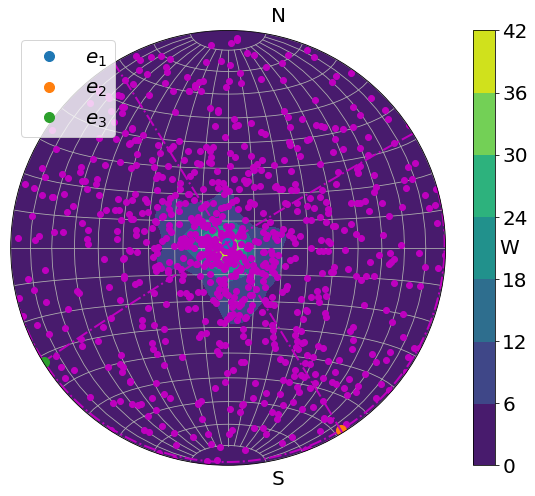

In [22]:
# Generate a random scatter of planes around the given plane
# All measurements follow the right-hand-rule to indicate dip direction
strike, dip = 50, 15
num = 900
strikesp = strike + 60 * np.random.randn(num)
dipsp = dip + 60 * np.random.randn(num)

#Find the average pole using linear algebra
w,E=axis_poles(strikesp,dipsp)

print('The Eigenvectors: \n',E)
print('The Eigenvalues:',w)
print('The trace of the Eigenvalues should be N (number of points): ',np.sum(np.diag(w)))


fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))

# Create filled contours of the poles of the generated planes...
# By default this uses a modified Kamb contouring technique with exponential
# smoothing (See Vollmer, 1995)
cax = ax.density_contourf(strikesp, dipsp, measurement='poles')

# Plot the poles as points on top of the contours
ax.pole(strikesp, dipsp,color='m')
ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
# Turn on a grid and add a colorbar
ax.grid(True)
fig.colorbar(cax)

#Plot the eigenvectors and auxiliary planes of the matrix
for i in range(0,len(E)):
    x,y,z=E[:,i] #Cartesian coordinates of eigenvector
    lon,lat=cart2sph(x,y,z)
    strike,dip=geographic2pole(lon,lat)
    #ax.pole(strike,dip,markersize=10,color='r')
    #ax.plane(strike,dip,'-.',lw=2,color='m')
    ax.pole(strike,dip,markersize=10,label='$e_'+np.str(i+1)+'$')
    ax.plane(strike,dip,'-.',lw=2,color='m')
    ax.legend()
    #print(x,y,z)
ax.grid(True) #Remove the grid lines
plt.show()

#print('Sum of position vectors: ',np.sum(V**2,axis=0))

# Calculate the optimal concentrations

## Maximize the log-likelihood function

Take the matrix $E$ estimated and maximize the likelihood function to get $k_1$ and $k_2$.  In order to do that, we need and expression for the likelihood first and then take the logarithm of that function.  When you do that, the Maximum Log-Likelihood Estimator for the set of $N$ poles following a Bingham distribution is:

$$\mathcal{L}(E,K)= -N\ln(4\pi)-N d(k_1,k_2)+k_1 \lambda_{min}+k_2 \lambda_{int}$$

where $d(k_1,k_2)$ is the normalization constant of the distribution and the most computationally intensive part of the equation. **"The likelihood of the observed data given the parameters can easily be written down and at first
glance it appears that maximum likelihood inference for K is straightforward. However, inferring
the matrix K is rather challenging. That is due to the fact that the likelihood of the observed data given the matrix K involves the parameter-dependent normalising constant d(K) which,
in the general case, is not available in closed form. Therefore this poses significant challenges
to undertake statistical inference involving the Bingham distribution either in a frequentist or
Bayesian setting. Fallaize & Kypraios (2018)"**

The optimization implemented to maximize the log-likelihood in the code below uses the Nelder-Mead algorithm.  This algorithm is one of a family of *heuristic optimization* techniques (e.g Genetic algorithms, Particle Swarms).  The algorithm does not need an analytical expression for the maximization to work, as other methods using derivatives, because it just samples the log-likelihood function by means of **simplex** structures.  A simplex is the extension of a traingle to higher dimensions. It is like exploring the function by successive triangulations that get you closer to the maximum on each iteration.

In [23]:
from scipy.optimize import minimize

#print('The Eigenvectors: \n',E)
#print('The Eigenvalues: \n',w)
#Sort the eigenvectors to follow the convention needed for the Bingham distribution
ws,Es=sort_eig(w,E)
print('The Sorted Eigenvectors: \n',Es)
print('The Sorted Eigenvalues: \n',ws)

#Define the log-likelihood function (set it as negative to be minimize)
def log_likelihood(params):
    k1,k2=params
    #The log-likelihood
    Sum=-num*np.log(4*np.pi)-num*np.log(norm_bingham_onstott(k1,k2))+k1*ws[0]+k2*ws[1] #
    return -Sum 

params0=np.array([-ws[1],-ws[0]])
res=minimize(log_likelihood,params0,method='Nelder-Mead',options={'disp': True},tol=1e-6)
k1,k2=res.x
print('k1 and k2 values',k1,k2)
print(res.x)

The Sorted Eigenvectors: 
 [[-0.00828565 -0.03024835  0.99950807]
 [ 0.85080123 -0.52541315 -0.00884779]
 [ 0.52542231  0.85030939  0.03008872]]
The Sorted Eigenvalues: 
 [186.54225297 227.78726536 485.67048167]
Optimization terminated successfully.
         Current function value: 2074.677579
         Iterations: 70
         Function evaluations: 128
k1 and k2 values -2.4013022859742503 -1.8095255148758094
[-2.40130229 -1.80952551]


# Plot the probability values over the points

Assign the Bingham probability to each point as a scatter plot.  This visualization helps you identify which points of the dataset you are fitting have the maximum and minimum probability given the directions and concentrations of the axes of the Bingham distribution they should belong to.

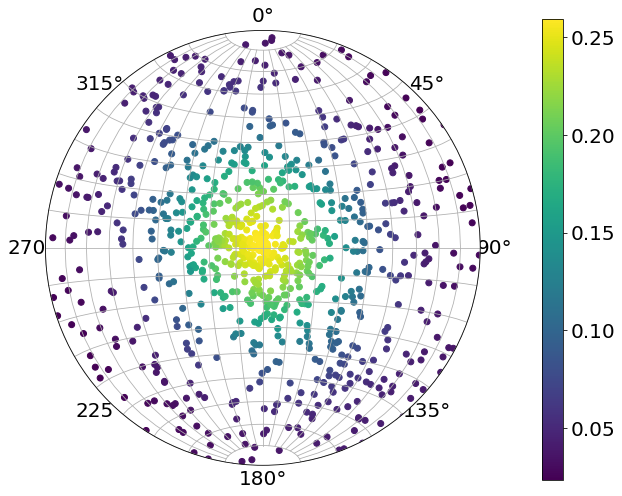

In [24]:
Prob_B=prob_bingham_sd(Es,k1,k2,strikesp,dipsp)

long,lati=pole(strikesp,dipsp)

fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))
p1=ax.scatter(long,lati,c=Prob_B)
#Define the Colorbar
#-- obtaining the colormap limits
vmin,vmax = p1.get_clim()
#-- Defining a normalised scale
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#-- Creating a new axes at the right side
ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#-- Plotting the colormap in the created axes
cb1 = mpl.colorbar.ColorbarBase(ax3, norm=cNorm)
ax.grid(True) #Remove the grid lines
plt.show()

# Create truly Bingham-distributed points based on the concentartions and principal directions estimated

This is how points on the stereonet would be distributed if they followed a Bingham distribution of $E$ and $K$ parameters. 

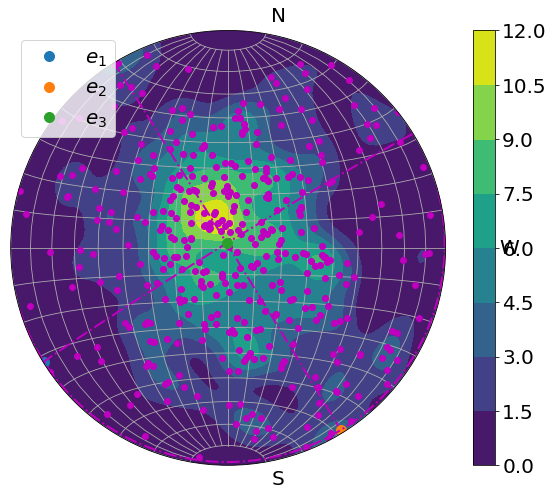

In [25]:
n=400
x,y,z=pbingham_EK(n,Es,k1,k2) #Generate n points from symmetric matrix M

#Plot the distribution
fig, ax = plt.subplots(figsize=(10,8),subplot_kw=dict(projection='stereonet'))
lon,lat=cart2sph(x,y,z) #transform the (x,y,z) coords to (lon,lat)
strike,dip=geographic2pole(lon,lat) #transform (lon, lat) to (strike, dip)
#Contour the data
cax = ax.density_contourf(strike, dip, measurement='poles') 

# Plot the poles as points on top of the contours
ax.pole(strike,dip,color='m')
ax.set_azimuth_ticklabels(['N', '','W', '', 'S', '', 'E', ''])
# Turn on a grid and add a colorbar
ax.grid(True)
fig.colorbar(cax)

#Plot the eigenvectors
#Plot the eigenvectors and auxiliary planes of the matrix
for i in range(0,len(Es)):
    x,y,z=Es[:,i] #Cartesian coordinates of eigenvector
    lon,lat=cart2sph(x,y,z)
    strike,dip=geographic2pole(lon,lat)
    #ax.pole(strike,dip,markersize=10,color='r')
    #ax.plane(strike,dip,'-.',lw=2,color='m')
    ax.pole(strike,dip,markersize=10,label='$e_'+np.str(i+1)+'$')
    ax.plane(strike,dip,'-.',lw=2,color='m')
    ax.legend()
    #print(x,y,z)
    ax.grid(True) #Remove the grid lines

plt.show()

# Maximize the Log-likelihood function in a different way

Define the log-likelihood function in a different way, more like matrix brute force

In [26]:
from scipy.optimize import minimize

#Sort the eigenvectors to follow the convention needed for the Bingham distribution
ws,Es=sort_eig(w,E)

#Define the log-likelihood function (set it as negative to be minimize)
def log_likelihood2(params):
    k1,k2=params
    #Define the K matrix
    K=np.diag(np.array([k1,k2,0]))
    #The matrix to be multiplied
    sigma_r=Es@K@Es.T #Proper multiplication or this -> [np.dot(E,np.dot(sigma_0,E.T))]
    ###########CALCULATING THE VALUES########################################################### 
    sigmas_n=[]
    for i in range(0,len(strikesp)):
        n=fnormal(strikesp[i], dipsp[i])
        #1) Projection of the stress tensor on the plane (vector on plane)
        Tn=np.dot(sigma_r,n)
        #2) Projection of Tn in the direction of the normal vector
        sigma_n=np.dot(Tn,n)
        sigmas_n=np.append(sigmas_n,sigma_n)
    #A=norm_bingham(k1,k2)#np.sum(sigmas_n) #The rough integration
    A=4*np.pi*norm_bingham_onstott(k1,k2)
    #The log-likelihood
    Sum=np.sum(sigmas_n)-num*np.log(A)
    return -Sum 

params0=np.array([-ws[1],-ws[0]])
res=minimize(log_likelihood2,params0,method='Nelder-Mead',options={'disp': True},tol=1e-6)
k1,k2=res.x
print('k1 and k2 values',k1,k2)
print(res.x)

Optimization terminated successfully.
         Current function value: 2074.677579
         Iterations: 70
         Function evaluations: 128
k1 and k2 values -2.4013022859742503 -1.8095255148758094
[-2.40130229 -1.80952551]
